In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,ReLU,BatchNormalization,Add,GlobalAveragePooling2D,InputLayer,Flatten,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import GradientTape
from tensorflow.nn import l2_normalize,local_response_normalization
from tensorflow.keras.losses import binary_crossentropy
import os
import tarfile
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed(None)
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

This Notebook aims to create a learning model for face recognizion and tries to optimize it

In [2]:
path= "../input/lfwpeople"
images_path="../working"

with tarfile.open(path+"/lfw-funneled.tgz","r:gz") as tar:
    tar.extractall("../working")

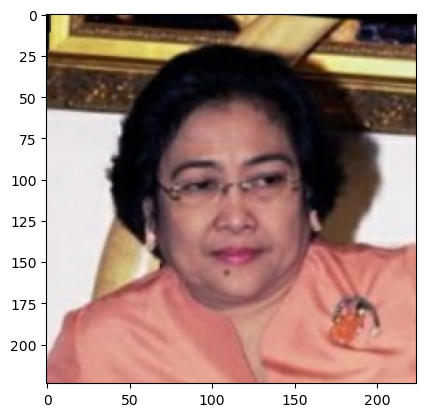

In [3]:
# an overview of the image
def show_image(file):
    def _show_image(file):
        img = tf.io.read_file(file)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = img[tf.newaxis, :]
        return img / 255.0
#     to use python function and bypass the tensorflow graph
    img = tf.py_function(_show_image, [file], tf.float32)
    img.set_shape((1, 224, 224, 3))
    return img

img=show_image("lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0023.jpg")
plt.imshow(img[0])

In [4]:
# Adding a few of them to a database, these will be the recognized subject
database={}
database["megawati"]="lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0023.jpg"
database["sby"]="lfw_funneled/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0001.jpg"
database["jackie_chan"]="lfw_funneled/Jackie_Chan/Jackie_Chan_0001.jpg"

our loss function will use the following triplett loss formula :
<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*EgT2EhqKW5hVrNYX6Y-rKg.png">
whereas :
* A : Anchor
* P : Positive
* N : Negative

In [69]:
@tf.function
def triplet_loss(y_pred, alpha=0.2):
    """
    Triplet loss function.
    
    Args:
    y_pred -- list containing the anchor, positive, and negative embeddings
    alpha -- margin , like SVM which because we want the distance between anchor to truth to be
            as wider as possible against the distance of anchor to false
    
    Returns:
    loss -- computed triplet loss
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
#     takes the max of loss and 0 to ensure the loss is non negative
    loss = tf.maximum(loss, 0.0)
    
    return loss

In [6]:
# Get positive (exist in database) and negative example
def get_pos():    
    anchor_dir=["lfw_funneled/Megawati_Sukarnoputri/",
    "lfw_funneled/Susilo_Bambang_Yudhoyono/",
    "lfw_funneled/Jackie_Chan/"]
    anchor_dir=random.choice(anchor_dir)
    anchor_list=os.listdir(anchor_dir)
    anchor=random.choice(anchor_list)
    pos=random.choice(anchor_list)
    while(pos==anchor):
        pos=random.choice(anchor_list)
    pos=anchor_dir+pos
    anchor=anchor_dir+anchor
    return anchor,pos

def get_neg():
    anchor_dir=["lfw_funneled/Megawati_Sukarnoputri/",
    "lfw_funneled/Susilo_Bambang_Yudhoyono/",
    "lfw_funneled/Jackie_Chan/"]
    train_neg="lfw_funneled/"
    neg_dir=os.listdir(train_neg)
    neg_dir=train_neg+random.choice(neg_dir)
    while(not os.path.isdir(neg_dir) or neg_dir in anchor_dir):
        neg_dir=train_neg+random.choice(neg_dir)
    neg_list=os.listdir(neg_dir)
    neg=random.choice(neg_list)
    neg=neg_dir+"/"+neg
    return neg

In [10]:
def in_database(file,model,use_sigmoid=False):
    """
    check whether or not image is in database
    """
    target=show_image(file)
    min_dist=10000
    target=model(target)
    name=None
    for keys,values in database.items():
        val=model(show_image(values))
        dist=np.linalg.norm(target-val)
        
        if dist<min_dist:
            min_dist=dist
            name=keys
#            a modified version
    if use_sigmoid:
        min_dist=tf.sigmoid(min_dist)
        min_dist=custom_loss(min_dist)
        if min_dist > 0.8655814:
            print(f"you look like {name} but you`re not, dist : {min_dist}")
        else:
            print(f"welcome {name}, dist : {min_dist}")
    else:
        if min_dist > 0.7:
            print(f"you look like {name} but you`re not, dist : {min_dist}")
        else:
            print(f"welcome {name}, dist : {min_dist}")
        

In [87]:
# baseline model
class Model(tf.keras.Model):
    def __init__(self):
        super(Model,self).__init__()
        self.inputs=InputLayer(input_shape=(224,224,3))
        self.conv1=Conv2D(64,(7,7),strides=1,activation="relu",padding="same")
        self.conv2=Conv2D(128,(3,3),strides=1,activation="relu",padding="same")
        self.conv3=Conv2D(128,(3,3),strides=1,activation="relu",padding="same")
        self.conv3a=Conv2D(128,(1,1),strides=1,activation="relu",padding="same")
        self.dense1=Dense(64)
        self.dense2=Dense(32)
        
    def call(self,inputs):
        out = self.inputs(inputs)
        out = self.conv1(out)
        out = self.conv2(out)
        out = MaxPooling2D((2,2)) (out)
#         out = local_response_normalization(out)
        out = self.conv3(out)
        out = MaxPooling2D((2,2)) (out)
        out = self.conv3a(out)
#         out = local_response_normalization(out)
        out = Flatten()(out)
        out = self.dense1(out)
        out = self.dense2(out)
#         in theory, i should use l2 normalization, but somehow it didnt work that well
#         out = l2_normalize(out)

        return out

In [88]:
model=Model()
optimizer=Adam(learning_rate=0.0001)

In [89]:
@tf.function
def train_step(anchor,pos,neg):
    with GradientTape() as tape:
        pred0=model(show_image(anchor))
        pred1=model(show_image(pos))
        pred2=model(show_image(neg))
        
        loss=triplet_loss([pred0,pred1,pred2])
    
    gradients=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

In [118]:
# train
for i in range(10):
    anchor,pos=get_pos()
    neg=get_neg()
    loss=train_step(anchor,pos,neg)
    print(f"step {i+1} loss {loss}")

step 1 loss 0.0
step 2 loss 0.0
step 3 loss 0.0
step 4 loss 0.0660552978515625
step 5 loss 0.09139198064804077
step 6 loss 0.0
step 7 loss 0.0
step 8 loss 0.0
step 9 loss 0.43173402547836304
step 10 loss 0.0


In [119]:
# testing with random negative examples
for i in range(10):
    neg=get_neg()
    print(neg)
    in_database(neg,model)
    print("================================")

lfw_funneled/Jackie_Dennis/Jackie_Dennis_0001.jpg
you look like sby but you`re not, dist : 1.165120244026184
lfw_funneled/Michael_Winterbottom/Michael_Winterbottom_0003.jpg
you look like sby but you`re not, dist : 1.3533529043197632
lfw_funneled/Lucio_Cecchinello/Lucio_Cecchinello_0001.jpg
you look like megawati but you`re not, dist : 0.7841628789901733
lfw_funneled/Jim_Paxson/Jim_Paxson_0001.jpg
you look like megawati but you`re not, dist : 1.111689567565918
lfw_funneled/Isabella_Rossellini/Isabella_Rossellini_0001.jpg
you look like megawati but you`re not, dist : 0.8351484537124634
lfw_funneled/Khatol_Mohammad_Zai/Khatol_Mohammad_Zai_0001.jpg
you look like megawati but you`re not, dist : 1.4169440269470215
lfw_funneled/Steve_Wariner/Steve_Wariner_0001.jpg
you look like sby but you`re not, dist : 1.1989140510559082
lfw_funneled/Adriana_Lima/Adriana_Lima_0001.jpg
you look like sby but you`re not, dist : 1.513939619064331
lfw_funneled/Iban_Mayo/Iban_Mayo_0001.jpg
welcome megawati, dist 

In [120]:
# testing with positive examples
in_database("lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0001.jpg",model=model)
in_database("lfw_funneled/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0002.jpg",model=model)
in_database("lfw_funneled/Jackie_Chan/Jackie_Chan_0003.jpg",model=model)

welcome megawati, dist : 0.5908611416816711
welcome sby, dist : 0.19722171127796173
welcome jackie_chan, dist : 0.5965995192527771


In [121]:
for i in range(5):
    anchor,pos=get_pos()
    print(anchor)
    in_database(anchor,model)
    print("================================")
    print(pos)
    in_database(pos,model)
    print("================================")

lfw_funneled/Jackie_Chan/Jackie_Chan_0008.jpg
welcome jackie_chan, dist : 0.6737725138664246
lfw_funneled/Jackie_Chan/Jackie_Chan_0005.jpg
welcome jackie_chan, dist : 0.3818415701389313
lfw_funneled/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0003.jpg
welcome sby, dist : 0.289079487323761
lfw_funneled/Susilo_Bambang_Yudhoyono/Susilo_Bambang_Yudhoyono_0001.jpg
welcome sby, dist : 0.0
lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0016.jpg
you look like megawati but you`re not, dist : 1.0420678853988647
lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0020.jpg
you look like megawati but you`re not, dist : 1.1069958209991455
lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0018.jpg
welcome megawati, dist : 0.3792138695716858
lfw_funneled/Megawati_Sukarnoputri/Megawati_Sukarnoputri_0023.jpg
welcome megawati, dist : 0.0
lfw_funneled/Jackie_Chan/Jackie_Chan_0013.jpg
welcome jackie_chan, dist : 0.5781917572021484
lfw_funneled/Jackie_Chan/Jackie_Chan_0003.jpg
we

In [28]:
model.save_weights("model_weight_",save_format="tf")

Although the results seems great, it probably kind of overfitted As i tried to overfit the face recognition model over small example